In [79]:
import matplotlib.pyplot as plt

# sphinx_gallery_thumbnail_number = 4
import numpy as np
from scipy.signal import filtfilt

import pylops
from pylops.utils.wavelets import ricker

plt.close("all")
np.random.seed(10)

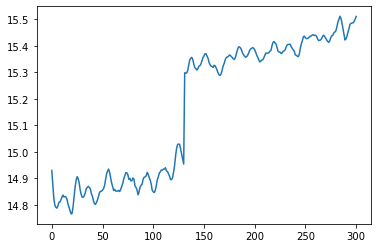

In [80]:
nt0 = 301
dt0 = 0.004
t0 = np.arange(nt0) * dt0
vp = 1200 + np.arange(nt0) + filtfilt(np.ones(5) / 5.0, 1, np.random.normal(0, 80, nt0))
rho = 1000 + vp + filtfilt(np.ones(5) / 5.0, 1, np.random.normal(0, 30, nt0))
vp[131:] += 500
rho[131:] += 100
m = np.log(vp * rho)

#plt.plot(vp)
#plt.plot(rho)
plt.plot(m)

plt.show()

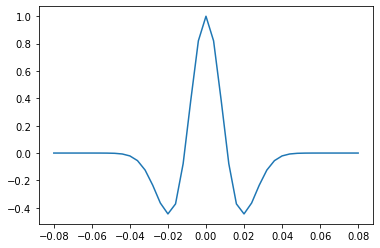

In [81]:
ntwav = 41
wav, twav, wavc = ricker(t0[: ntwav // 2 + 1], 20)

plt.plot(twav,wav)

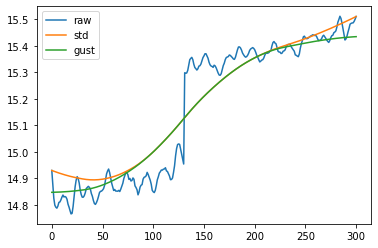

In [102]:
nsmooth = 100
mback_gust = filtfilt(np.ones(nsmooth) / float(nsmooth), 1, m, method = "gust")
mback = filtfilt(np.ones(nsmooth) / float(nsmooth), 1, m )
plt.plot(m , label = "raw")
plt.plot(mback, label = "std")
plt.plot(mback_gust, label = "gust")
plt.legend(loc = "best")

plt.show()

In [109]:
# dense operator
PPop_dense = pylops.avo.poststack.PoststackLinearModelling(
    wav / 2, nt0=nt0, explicit=True
)

# lop operator
PPop = pylops.avo.poststack.PoststackLinearModelling(wav / 2, nt0=nt0)

# data
d_dense = PPop_dense * m.ravel()
d = PPop * m

# add noise
dn_dense = d_dense + np.random.normal(0, 2e-2, d_dense.shape)

In [111]:
# We can now estimate the acoustic profile from band-limited data using either
# the dense operator or linear operator.

# solve dense
minv_dense = pylops.avo.poststack.PoststackInversion(
    d, wav / 2, m0=mback_gust, explicit=True, simultaneous=False
)[0]

# solve lop
minv = pylops.avo.poststack.PoststackInversion(
    d_dense,
    wav / 2,
    m0=mback_gust,
    explicit=False,
    simultaneous=False,
    **dict(iter_lim=2000)
)[0]

# solve noisy
mn = pylops.avo.poststack.PoststackInversion(
    dn_dense, wav / 2, m0=mback_gust, explicit=True, epsR=1e0, **dict(damp=1e-1)
)[0]

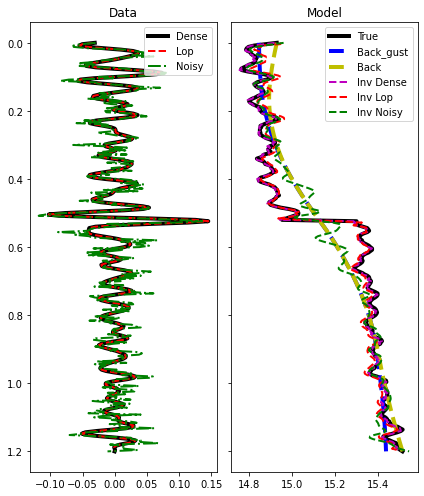

In [112]:
fig, axs = plt.subplots(1, 2, figsize=(6, 7), sharey=True)
axs[0].plot(d_dense, t0, "k", lw=4, label="Dense")
axs[0].plot(d, t0, "--r", lw=2, label="Lop")
axs[0].plot(dn_dense, t0, "-.g", lw=2, label="Noisy")
axs[0].set_title("Data")
axs[0].invert_yaxis()
axs[0].axis("tight")
axs[0].legend(loc=1)
axs[1].plot(m, t0, "k", lw=4, label="True")
axs[1].plot(mback_gust, t0, "--b", lw=4, label="Back_gust")
axs[1].plot(mback, t0, "--y", lw=4, label="Back")
axs[1].plot(minv_dense, t0, "--m", lw=2, label="Inv Dense")
axs[1].plot(minv, t0, "--r", lw=2, label="Inv Lop")
axs[1].plot(mn, t0, "--g", lw=2, label="Inv Noisy")
axs[1].set_title("Model")
axs[1].axis("tight")
axs[1].legend(loc=1)
plt.tight_layout()

In [27]:
# wavelet
ntwav = 41
f0s = np.flip(np.arange(nt0) * 0.05 + 3)
wavs = np.array([ricker(t0[:ntwav], f0)[0] for f0 in f0s])
wavc = np.argmax(wavs[0])

(0.0, 1.2, 0.164, -0.164)

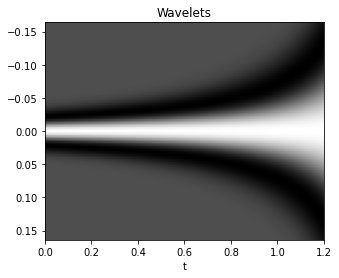

In [28]:
plt.figure(figsize=(5, 4))
plt.imshow(wavs.T, cmap="gray", extent=(t0[0], t0[-1], t0[ntwav], -t0[ntwav]))
plt.xlabel("t")
plt.title("Wavelets")
plt.axis("tight")

In [29]:
# operator
PPop = pylops.avo.poststack.PoststackLinearModelling(wavs / 2, nt0=nt0, explicit=True)

# data
d = PPop * m

# solve
minv = pylops.avo.poststack.PoststackInversion(
    d, wavs / 2, m0=mback, explicit=True, **dict(cond=1e-10)
)[0]

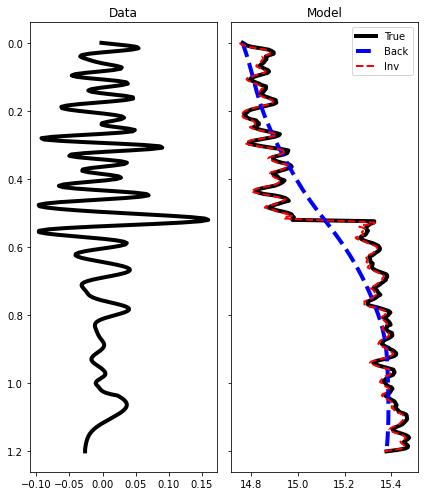

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(6, 7), sharey=True)
axs[0].plot(d, t0, "k", lw=4)
axs[0].set_title("Data")
axs[0].invert_yaxis()
axs[0].axis("tight")
axs[1].plot(m, t0, "k", lw=4, label="True")
axs[1].plot(mback, t0, "--b", lw=4, label="Back")
axs[1].plot(minv, t0, "--r", lw=2, label="Inv")
axs[1].set_title("Model")
axs[1].axis("tight")
axs[1].legend(loc=1)
plt.tight_layout()


In [114]:
inputfile = "poststack_model.npz"

In [115]:
model = np.load(inputfile)
m = np.log(model["model"][:, ::3])
x, z = model["x"][::3] / 1000.0, model["z"] / 1000.0
nx, nz = len(x), len(z)

In [118]:
# smooth model
nsmoothz, nsmoothx = 60, 50
mback = filtfilt(np.ones(nsmoothz) / float(nsmoothz), 1, m, axis=0)
mback = filtfilt(np.ones(nsmoothx) / float(nsmoothx), 1, mback, axis=1)

# dense operator
PPop_dense = pylops.avo.poststack.PoststackLinearModelling(
    wav / 2, nt0=nz, spatdims=nx, explicit=True
)

# lop operator
PPop = pylops.avo.poststack.PoststackLinearModelling(wav / 2, nt0=nz, spatdims=nx)

# data
d = (PPop_dense * m.ravel()).reshape(nz, nx)
n = np.random.normal(0, 1e-1, d.shape)
dn = d + n

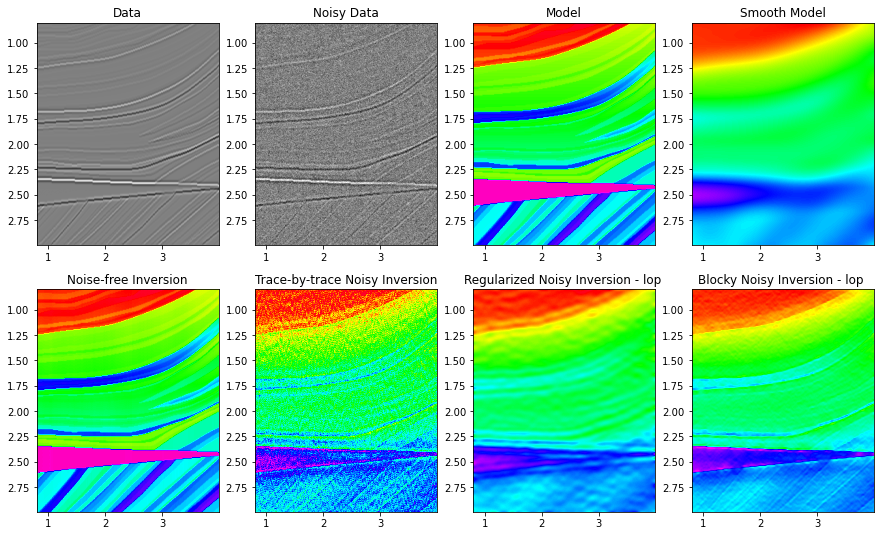

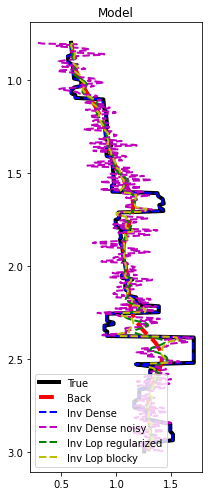

In [119]:
# dense inversion with noise-free data
minv_dense = pylops.avo.poststack.PoststackInversion(
    d, wav / 2, m0=mback, explicit=True, simultaneous=False
)[0]

# dense inversion with noisy data
minv_dense_noisy = pylops.avo.poststack.PoststackInversion(
    dn, wav / 2, m0=mback, explicit=True, epsI=4e-2, simultaneous=False
)[0]

# spatially regularized lop inversion with noisy data
minv_lop_reg = pylops.avo.poststack.PoststackInversion(
    dn,
    wav / 2,
    m0=minv_dense_noisy,
    explicit=False,
    epsR=5e1,
    **dict(damp=np.sqrt(1e-4), iter_lim=80)
)[0]

# blockiness promoting inversion with noisy data
minv_lop_blocky = pylops.avo.poststack.PoststackInversion(
    dn,
    wav / 2,
    m0=mback,
    explicit=False,
    epsR=[0.4],
    epsRL1=[0.1],
    **dict(mu=0.1, niter_outer=5, niter_inner=10, iter_lim=5, damp=1e-3)
)[0]

fig, axs = plt.subplots(2, 4, figsize=(15, 9))
axs[0][0].imshow(d, cmap="gray", extent=(x[0], x[-1], z[-1], z[0]), vmin=-0.4, vmax=0.4)
axs[0][0].set_title("Data")
axs[0][0].axis("tight")
axs[0][1].imshow(
    dn, cmap="gray", extent=(x[0], x[-1], z[-1], z[0]), vmin=-0.4, vmax=0.4
)
axs[0][1].set_title("Noisy Data")
axs[0][1].axis("tight")
axs[0][2].imshow(
    m,
    cmap="gist_rainbow",
    extent=(x[0], x[-1], z[-1], z[0]),
    vmin=m.min(),
    vmax=m.max(),
)
axs[0][2].set_title("Model")
axs[0][2].axis("tight")
axs[0][3].imshow(
    mback,
    cmap="gist_rainbow",
    extent=(x[0], x[-1], z[-1], z[0]),
    vmin=m.min(),
    vmax=m.max(),
)
axs[0][3].set_title("Smooth Model")
axs[0][3].axis("tight")
axs[1][0].imshow(
    minv_dense,
    cmap="gist_rainbow",
    extent=(x[0], x[-1], z[-1], z[0]),
    vmin=m.min(),
    vmax=m.max(),
)
axs[1][0].set_title("Noise-free Inversion")
axs[1][0].axis("tight")
axs[1][1].imshow(
    minv_dense_noisy,
    cmap="gist_rainbow",
    extent=(x[0], x[-1], z[-1], z[0]),
    vmin=m.min(),
    vmax=m.max(),
)
axs[1][1].set_title("Trace-by-trace Noisy Inversion")
axs[1][1].axis("tight")
axs[1][2].imshow(
    minv_lop_reg,
    cmap="gist_rainbow",
    extent=(x[0], x[-1], z[-1], z[0]),
    vmin=m.min(),
    vmax=m.max(),
)
axs[1][2].set_title("Regularized Noisy Inversion - lop ")
axs[1][2].axis("tight")
axs[1][3].imshow(
    minv_lop_blocky,
    cmap="gist_rainbow",
    extent=(x[0], x[-1], z[-1], z[0]),
    vmin=m.min(),
    vmax=m.max(),
)
axs[1][3].set_title("Blocky Noisy Inversion - lop ")
axs[1][3].axis("tight")

fig, ax = plt.subplots(1, 1, figsize=(3, 7))
ax.plot(m[:, nx // 2], z, "k", lw=4, label="True")
ax.plot(mback[:, nx // 2], z, "--r", lw=4, label="Back")
ax.plot(minv_dense[:, nx // 2], z, "--b", lw=2, label="Inv Dense")
ax.plot(minv_dense_noisy[:, nx // 2], z, "--m", lw=2, label="Inv Dense noisy")
ax.plot(minv_lop_reg[:, nx // 2], z, "--g", lw=2, label="Inv Lop regularized")
ax.plot(minv_lop_blocky[:, nx // 2], z, "--y", lw=2, label="Inv Lop blocky")
ax.set_title("Model")
ax.invert_yaxis()
ax.axis("tight")
ax.legend()
plt.tight_layout()